In [218]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/90+_DaysPastDue/90+DPD_files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

check the distributions 

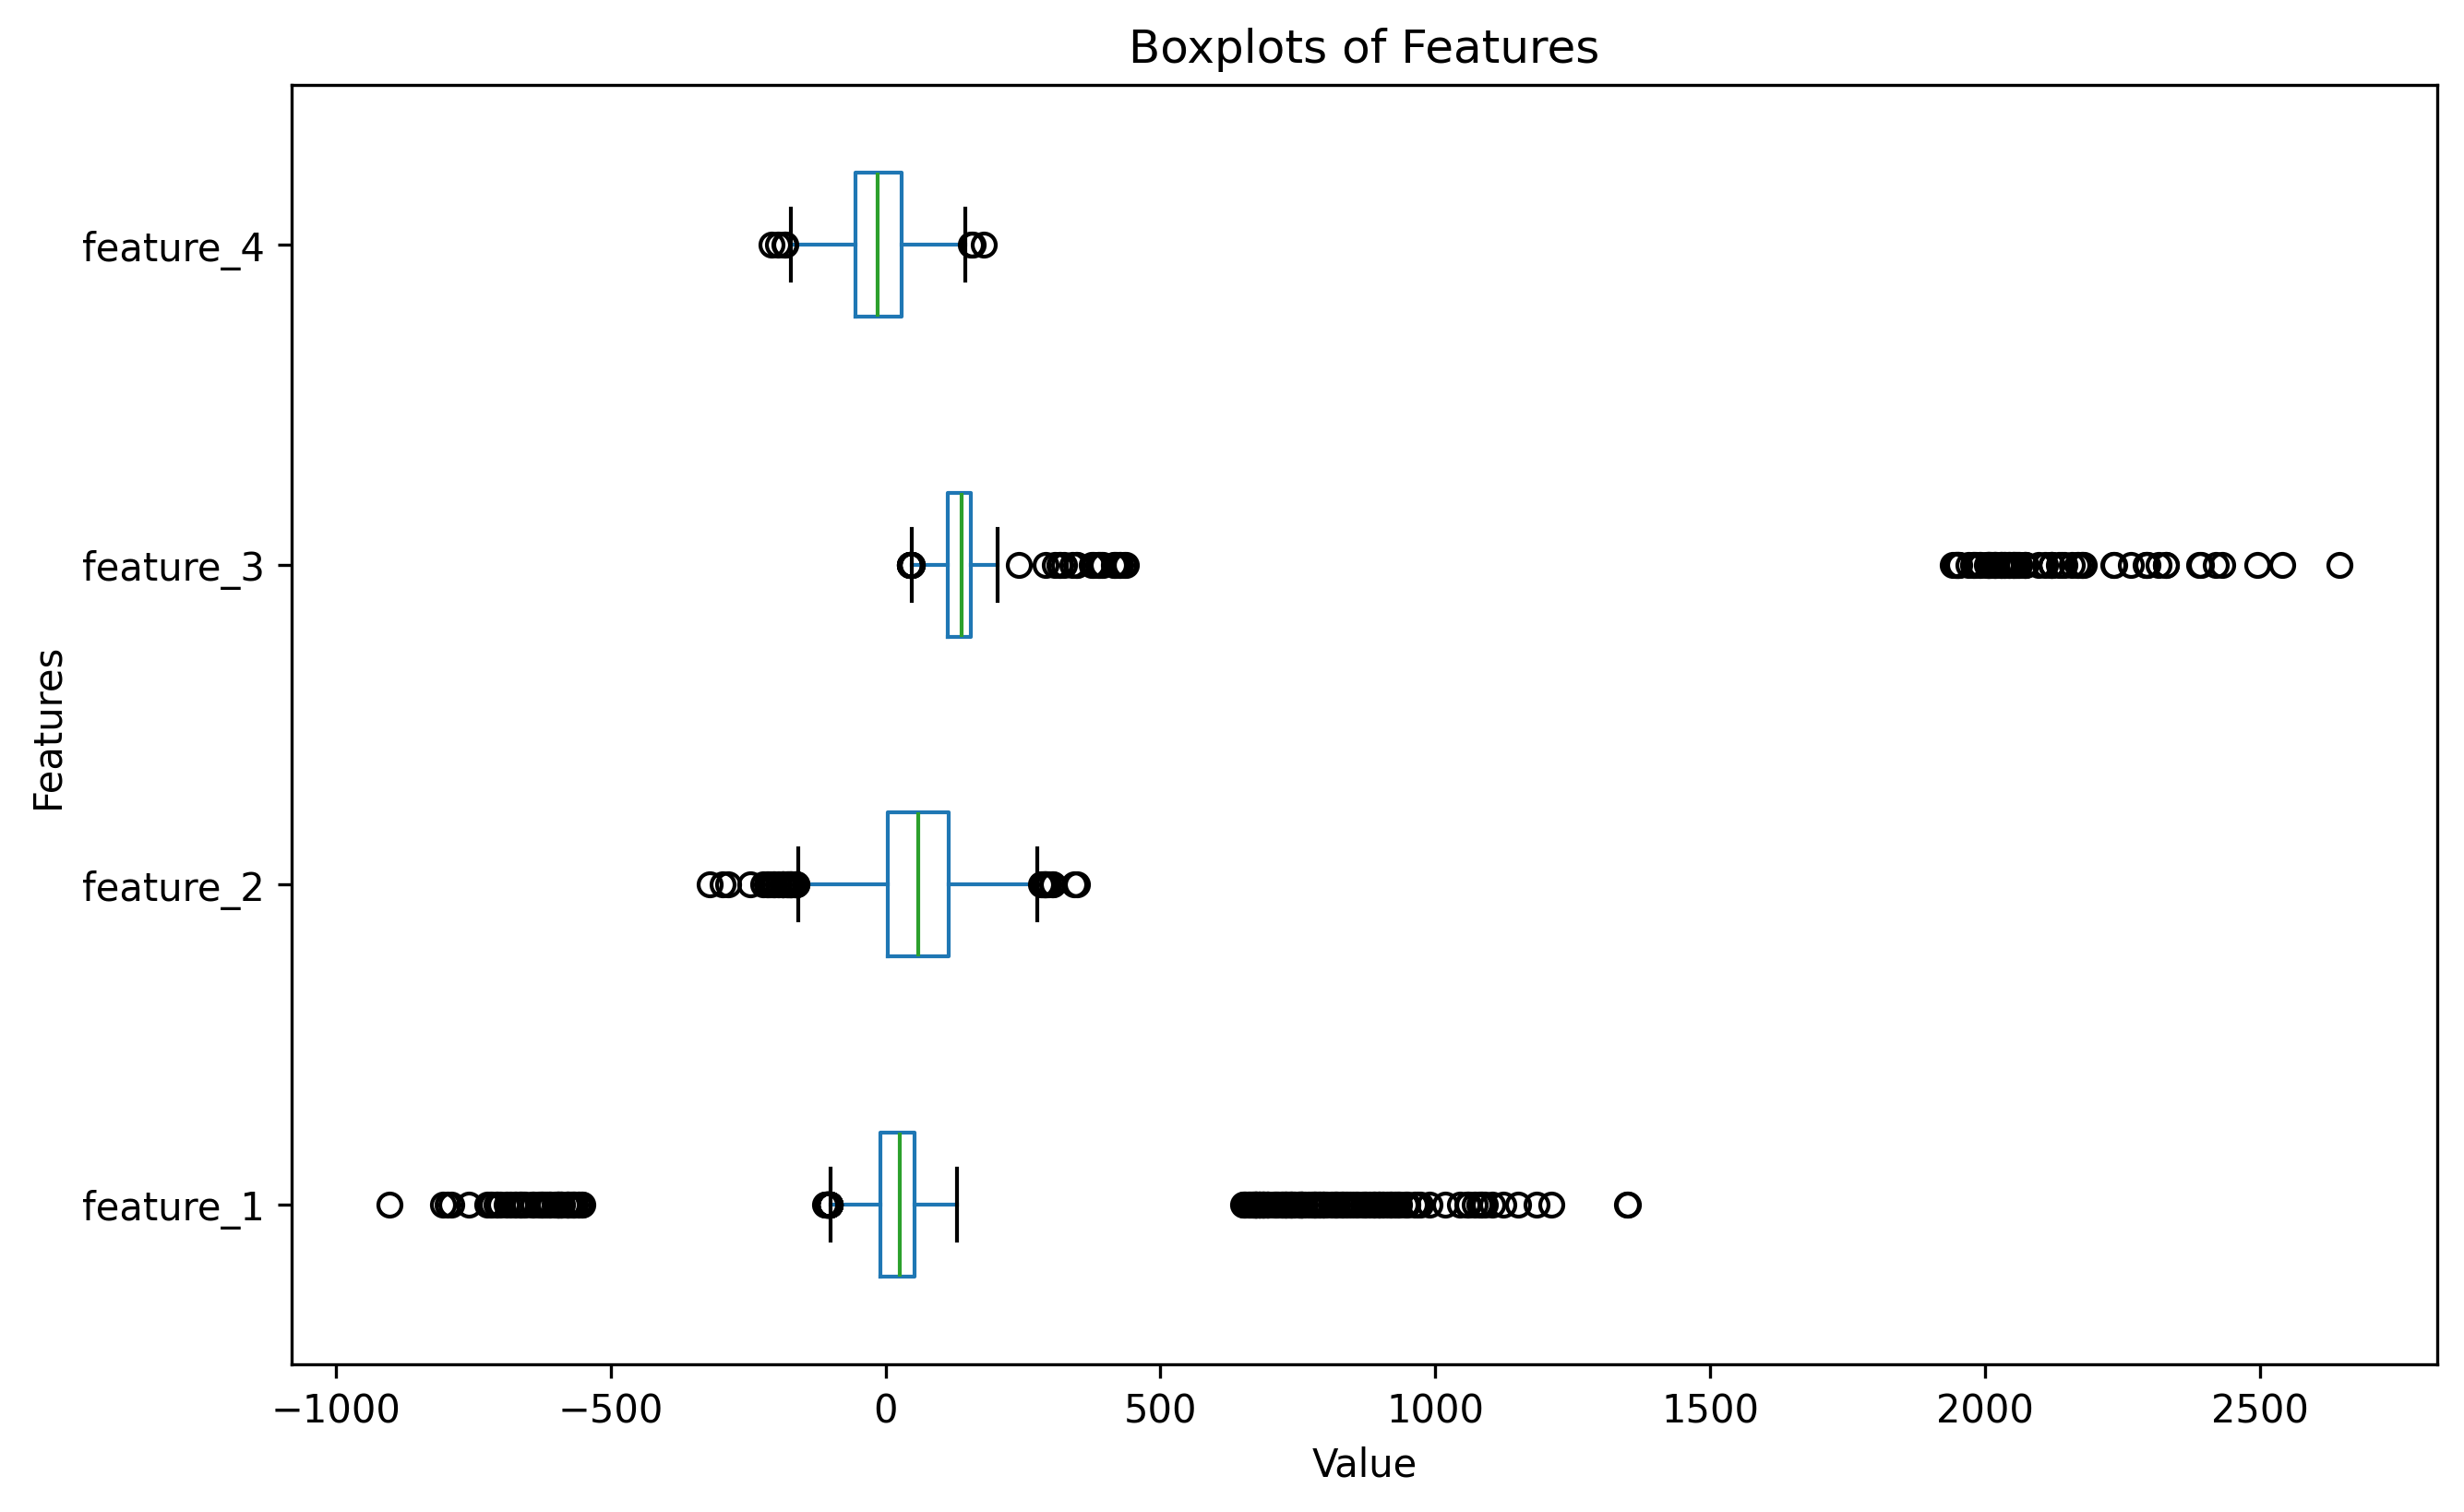

In [219]:

import pandas as pd
import matplotlib.pyplot as plt

features = ["feature_1", "feature_2", "feature_3", "feature_4"]

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Create boxplot
train[features].boxplot(grid=False, vert=False)
plt.title("Boxplots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

The outliers of feature 3 will yeild disproportioate weight to the model parameter for feature 3 in whatever model we build. We we need to remove these outliers. 

In [220]:
threshold = train['feature_3'].quantile(0.99)

train.loc[train['feature_3'] > threshold, 'feature_3'] = pd.NA

replace those values we just removed with median 

In [221]:
median_value = train['feature_3'].median()

train['feature_3'].fillna(median_value, inplace=True)

train.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)


median_value = test['feature_3'].median()

test['feature_3'].fillna(median_value, inplace=True)

test.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7138/1303804916.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['feature_3'].fillna(median_value, inplace=True)
/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7138/1303804916.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

sort by ID and date so that if feature 2 is missing we can replace it with the next year or the previous years value

In [222]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])  
    df['feature_2'] = df['feature_2'].fillna(method='bfill') 
    df['feature_2'] = df['feature_2'].fillna(method='ffill') 
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

train.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)
test.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)

train = train.dropna(subset=['feature_2_impute'])
test = test.dropna(subset=['feature_2_impute'])

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7138/960713373.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['feature_2'] = df['feature_2'].fillna(method='bfill')
/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7138/960713373.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['feature_2'] = df['feature_2'].fillna(method='ffill')
/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_7138/960713373.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('id', group_

encode outocomes to 1 and 0 

In [223]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [224]:
display(train.head())

,feature_1,feature_2_impute,feature_3_impute,feature_4,id,date,y
0,39.165085,60.253765,137.986051,-35.462685,50501,2000,0
1,-12.614289,57.959237,126.212293,44.420647,50501,2001,1
2,0.043813,-39.293907,138.687175,64.944112,50501,2002,0
3,2.296984,49.996686,123.782456,-3.587873,50501,2003,0
4,7.188897,-83.533230,150.102046,95.359641,50501,2004,0


Now that all the NA's are gone, 

Preliminary diagnostics for suitability of Logistic Regression. 

In [225]:
import statsmodels.api as sm

predictor = train[['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']]
response = train['y']

predictor_with_const = sm.add_constant(predictor)

logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.392452
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3941
Model:                          Logit   Df Residuals:                     3936
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.2248
Time:                        15:24:56   Log-Likelihood:                -1546.7
converged:                       True   LL-Null:                       -1995.2
Covariance Type:            nonrobust   LLR p-value:                7.445e-193
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.1690      0.288     14.494      0.000       3.605       4.733
feature_1 

feature 1 doesn't look very usefull, let's plot the logit curves of our predictors

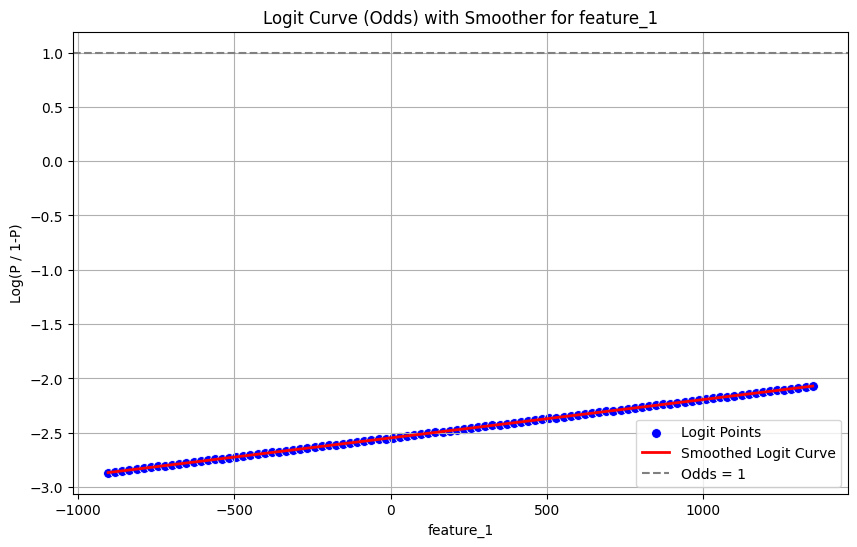

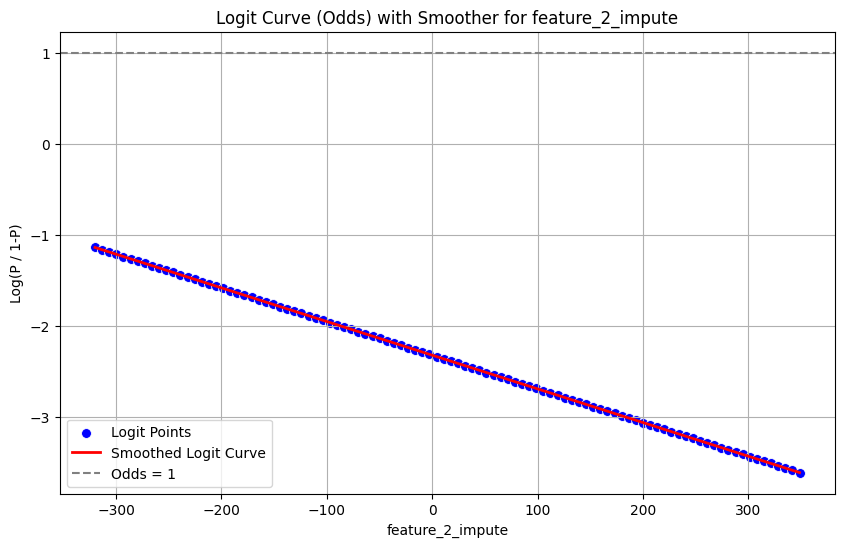

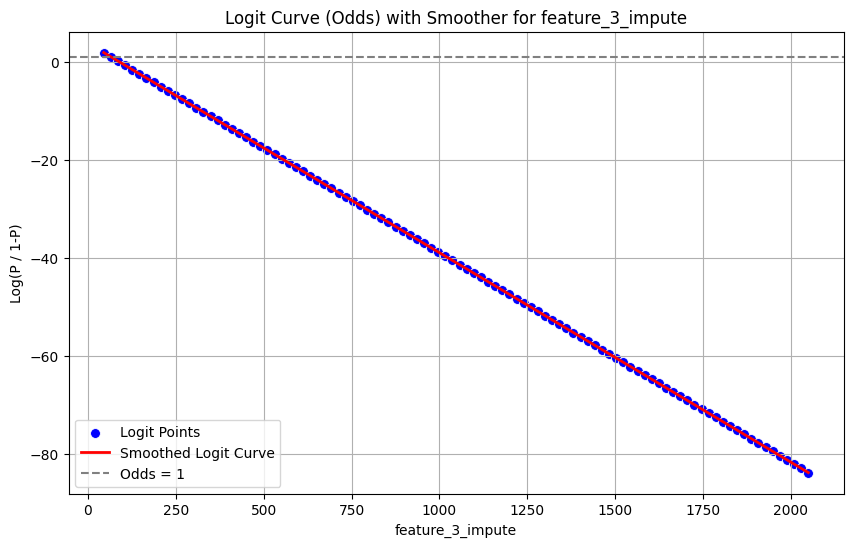

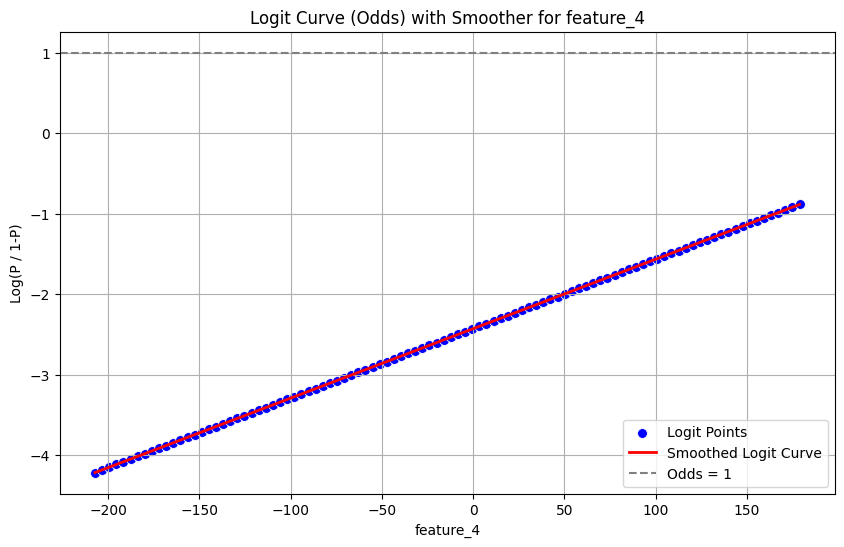

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_logit_curve_with_smoother(result, predictor, feature_name):
    """
    Plot the logit curve (odds) for a given feature with scatter points and a smoother.

    Parameters:
    - result: Fitted logistic regression model.
    - predictor: Training dataset of predictors.
    - feature_name: The feature for which to plot the logit curve.
    """
    # Generate a range of values for the selected feature
    feature_values = np.linspace(predictor[feature_name].min(), predictor[feature_name].max(), 100)
    
    # Keep other predictors fixed at their mean
    fixed_predictors = predictor.mean(axis=0).copy()
    
    # Calculate the logit (odds) for each feature value
    log_odds = []
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature_name] = value
        
        # Add constant and ensure shape matches model coefficients
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        #odds = np.exp(logit)  this is ploting the log(p/1-p) i just ommited the exp()
        log_odds.append(logit[0])
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        feature_name: feature_values,
        'log_odds': log_odds
    })
    
    # Plot the logit curve with points and smoother
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_name, y='log_odds', data=plot_df, color='blue', s=50, label='Logit Points')
    sns.regplot(x=feature_name, y='log_odds', data=plot_df, scatter=False, lowess=True, 
                color='red', line_kws={'lw': 2}, label='Smoothed Logit Curve')
    
    plt.title(f'Logit Curve (Odds) with Smoother for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Log(P / 1-P)')
    plt.axhline(1, color='grey', linestyle='--', label='Odds = 1')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_logit_curve_with_smoother(result, predictor, 'feature_1')
plot_logit_curve_with_smoother(result, predictor, 'feature_2_impute')
plot_logit_curve_with_smoother(result, predictor, 'feature_3_impute')
plot_logit_curve_with_smoother(result, predictor, 'feature_4')

Given that featue 4 nor feature 2 were detected as insignifigant by the modle summary, feature 1 is fine. 